# Prepare Data

In this notebook the main part of the data preparation takes place, according to the steps described in Section 4.4 of the report.

As final output, this notebook creates the file `data_matrix.csv` which is then further processed in the notebook `2_prepare_data_main_approach.ipynb`.

Throughout the process, additional files are created which can be stored in the data folder by setting the variable `SAVE_SECONDARY_FILES` to `True`. However, those data sets are not used further:
- `data_matrix_in_units.csv`
- `data_matrix_unit_tests.csv`
- `data_matrix_complete.csv`
- `class_students_comparison.csv`
- `class_mapping.json`
- `data_matrix_complete_classes_mapped.csv`

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append(os.path.abspath('../../sources'))

from data_preparation import restrict_data
import utils

C:\Users\Chiara\AppData\Local\Temp\ipykernel_1920\1915276829.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\Chiara\Documents\Uni_Master_MMDS\Masterarbeit\elearning-recommender\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
SAVE_PRIMARY_FILES = False
SAVE_SECONDARY_FILES = False

## Read Data

In [3]:
# load data
(
    action_logs_orig,
    unit_test_scores_orig,
    assignment_relationships_orig,
    assignment_details_orig,
    sequence_relationships_orig,
    sequence_details_orig,
    problem_details_orig
) = utils.load_all_data()

# restrict data
(
    assignment_details,
    sequence_details,
    problem_details,
) = restrict_data.restrict_details_to_available_assignments(
    action_logs_orig,
    unit_test_scores_orig,
    assignment_details_orig,
    sequence_details_orig,
    problem_details_orig,
)

## Preparing the IU Assignments

according to Subsection 4.4.1

In [4]:
action_logs_orig

,assignment_log_id,timestamp,problem_id,max_attempts,available_core_tutoring,score_viewable,continuous_score_viewable,action,hint_id,explanation_id
0,2QV1F2GSBZ,1.599151e+09,NaN,NaN,NaN,NaN,NaN,assignment_started,NaN,NaN
1,2QV1F2GSBZ,1.599151e+09,I2GX4OQIE,3.0,answer,1.0,1.0,problem_started,NaN,NaN
2,2QV1F2GSBZ,1.599151e+09,I2GX4OQIE,NaN,NaN,NaN,NaN,wrong_response,NaN,NaN
3,2QV1F2GSBZ,1.599151e+09,I2GX4OQIE,NaN,NaN,NaN,NaN,wrong_response,NaN,NaN
4,2QV1F2GSBZ,1.599151e+09,I2GX4OQIE,NaN,NaN,NaN,NaN,answer_requested,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
23932271,1VVEB3EAGF,1.634919e+09,NaN,NaN,NaN,NaN,NaN,continue_selected,NaN,NaN
23932272,1VVEB3EAGF,1.634919e+09,20GKDUW4FH,1.0,no_tutoring,1.0,0.0,problem_started,NaN,NaN
23932273,1VVEB3EAGF,1.634919e+09,20GKDUW4FH,NaN,NaN,NaN,NaN,open_response,NaN,NaN
23932274,1VVEB3EAGF,1.634919e+09,20GKDUW4FH,NaN,NaN,NaN,NaN,problem_finished,NaN,NaN


In [5]:
all_actions = action_logs_orig["action"].unique()
all_actions

array(['assignment_started', 'problem_started', 'wrong_response',
       'answer_requested', 'correct_response', 'problem_finished',
       'continue_selected', 'open_response', 'assignment_finished',
       'assignment_resumed', 'explanation_requested',
       'skill_related_video_requested', 'hint_requested',
       'live_tutor_requested'], dtype=object)

In [6]:
answer_actions = ["correct_response", "wrong_response", "open_response", "answer_requested"]
help_actions = ["explanation_requested", "skill_related_video_requested", "hint_requested", "live_tutor_requested"]
border_actions = ["problem_started", "problem_finished"]
unused_actions = ["assignment_started", "assignment_resumed", "assignment_finished", "continue_selected"]

Create a dataframe which contains all relevant information for each problem in each assignment.

Before creating the dataframe, all logs for the unused actions are removed. As every problem begins with the action "problem_started", problems which only have the action "problem_started" are removed, too.

In [7]:
action_logs_orig["action"].value_counts()

action
problem_started                  5245860
problem_finished                 5140911
continue_selected                4602358
correct_response                 3587501
wrong_response                   1580102
open_response                    1541432
assignment_started                638528
answer_requested                  603988
assignment_finished               531285
assignment_resumed                364544
hint_requested                     73343
explanation_requested              21136
skill_related_video_requested       1130
live_tutor_requested                 158
Name: count, dtype: int64

### Initial Data Cleaning

Store information if assignments have been started and finished.

In [8]:
# get assignment_log_ids for assignments that have been started and that have been finished
ids_ass_started = action_logs_orig.loc[
    action_logs_orig["action"] == "assignment_started", "assignment_log_id"
].unique()
ids_ass_finished = action_logs_orig.loc[
    action_logs_orig["action"] == "assignment_finished", "assignment_log_id"
].unique()
print(len(ids_ass_started), len(ids_ass_finished), len(set(ids_ass_started) & set(ids_ass_finished)))
# 638528, 531279, 531279

638528 531279 531279


All assignments have been started, but some have not been finished. We keep them for now and analyze whether we further use them at a later stage.

In [9]:
# drop rows having unused actions
# all columns except for assignment_log_id, timestamp and action are null for those rows
action_logs = action_logs_orig.loc[~action_logs_orig["action"].isin(unused_actions)].copy()
print(len(action_logs))  # 17795561

# drop problems that only have action "problem_started"
num_actions = action_logs.groupby(by=["assignment_log_id", "problem_id"])["action"].size()
filtered_groups = num_actions[num_actions >= 2]
action_logs = (
    action_logs.set_index(["assignment_log_id", "problem_id"])
    .loc[filtered_groups.index]
    .reset_index()
)
print(len(action_logs))  # 17705834

# sort logs by timestamp (such that row with "problem_started" is chosen in next step)
action_logs = action_logs.sort_values(by=["timestamp"])
action_logs_save = action_logs.copy()
action_logs.head()  # 17705834

17795561
17705834


,assignment_log_id,problem_id,timestamp,max_attempts,available_core_tutoring,score_viewable,continuous_score_viewable,action,hint_id,explanation_id
14909548,KMQMUDOYN,9OLB1D1BS,1.551122e+09,3.0,hint,1.0,1.0,problem_started,NaN,NaN
2828966,1FHXMNVBIY,9OLB1D1BS,1.551122e+09,3.0,hint,1.0,1.0,problem_started,NaN,NaN
14695512,JGI94725R,9OLB1D1BS,1.551123e+09,3.0,hint,1.0,1.0,problem_started,NaN,NaN
7287266,23Y57OUDNM,9OLB1D1BS,1.551123e+09,3.0,hint,1.0,1.0,problem_started,NaN,NaN
1050237,15QDVQG2O6,9OLB1D1BS,1.551123e+09,3.0,hint,1.0,1.0,problem_started,NaN,NaN


#### Drop problems that are not in problem_details

In [10]:
num_prob_old = action_logs["problem_id"].nunique()
len_old = len(action_logs)
action_logs = action_logs.loc[action_logs["problem_id"].isin(problem_details.index)]
num_prob_new = action_logs["problem_id"].nunique()
len_new = len(action_logs)
print(f"Removed {num_prob_old - num_prob_new} problems corresponding to {len_old - len_new} rows.")
# 819, 342401

Removed 819 problems corresponding to 342401 rows.


#### Open Response Problems

we decided to drop all problems having problem type "Ungraded Open Response". Problems for which the problem type is not "Ungraded Open Response" but the performed action is "open_response" are kept. As the proportion of those among the whole data is quite low, we do not handle them separately but treat the action "open_response" equally to the action "correct_response".

In [11]:
# get one row per assignment and problem
al = action_logs.drop_duplicates(subset=["assignment_log_id", "problem_id"])

# merge problem type
al = al.merge(problem_details["problem_type"], how="left", left_on="problem_id", right_index=True)

# get number of records per problem type
val_counts = al["problem_type"].value_counts()
display(val_counts)

# get number of problems with problem type Ungraded Open Response
num_uor = val_counts["Ungraded Open Response"]
print(f"There are {num_uor} problems with problem type Ungraded Open Response.")  # 1556245
print(f"This corresponds to {(num_uor / len(al))*100:.2f}% of all records.")  # 30.78%

# compare number of assignments
num_ass_old = al["assignment_log_id"].nunique()  # 595863
num_ass_new = al.loc[al["problem_type"] != "Ungraded Open Response", "assignment_log_id"].nunique()  # 534092
print(f"Number of assignments has been reduced from {num_ass_old} to {num_ass_new}")

problem_type
Number                          2274118
Ungraded Open Response          1556245
Multiple Choice                  544926
Algebraic Expression             301858
Exact Match (ignore case)        165463
Check All That Apply              76049
Exact Fraction                    52724
Numeric Expression                40178
Exact Match (case sensitive)      28112
Ordering                          16012
Name: count, dtype: int64

There are 1556245 problems with problem type Ungraded Open Response.
This corresponds to 30.78% of all records.
Number of assignments has been reduced from 595863 to 534092


In [12]:
uor_probs = problem_details.loc[problem_details["problem_type"] == "Ungraded Open Response"].index

old_len = len(action_logs)  # 17363433

# drop problems having problem type "Ungraded Open Response"
action_logs = action_logs.loc[~action_logs["problem_id"].isin(uor_probs)].copy()

new_len = len(action_logs)  # 12666244
print(f"Action logs has been reduced from {old_len} to {new_len} records.")

Action logs has been reduced from 17363433 to 12666244 records.


### Aggregating the Data

Now, we create the summarizing dataframe.

In [13]:
# create dataframe with one row for each problem_id in each assignment
grouped = action_logs.groupby(["assignment_log_id", "problem_id"])
# get introduction row for each problem in each assignment
df = grouped.first()[["timestamp", "available_core_tutoring"]]
print(len(df))  # 3499440

# get all actions and number of actions
action_list = grouped["action"].apply(list).rename("actions")
df = df.merge(action_list, how="left", left_index=True, right_index=True)
df["num_actions"] = df["actions"].apply(lambda action_list: len(action_list))

# get first actions
first_actions = grouped.nth(1).set_index(["assignment_log_id", "problem_id"])
df = df.merge(first_actions["action"], how="left", left_index=True, right_index=True)
print("Unique first actions:", df["action"].unique())
# treat case where problem is started twice
mask_started_twice = df["action"] == "problem_started"
df.loc[mask_started_twice, "actions"] = df.loc[mask_started_twice, "actions"].apply(
    lambda action_list: action_list[1:]
)
df.loc[mask_started_twice, "action"] = df.loc[mask_started_twice, "actions"].apply(
    lambda action_list: action_list[1]
)

num_or = df["action"].value_counts()["open_response"]  # 44477
print(f"There are {num_or} problems ({(num_or / len(df)) * 100:.2f}%) for which the first action is 'open_response'.")
# 1.27%

# determine if first answer was correct (correct or open_response) or wrong
df["first_answer"] = 0
df.loc[df["action"].isin(["correct_response", "open_response"]), "first_answer"] = 1
df = df.drop(columns="action")

3499440
Unique first actions: ['wrong_response' 'correct_response' 'answer_requested' 'open_response'
 'explanation_requested' 'hint_requested' 'skill_related_video_requested'
 'live_tutor_requested' 'problem_started']
There are 44477 problems (1.27%) for which the first action is 'open_response'.


In [14]:
# get last actions and determine if problem has been finished
last_actions = grouped.last()
last_actions["problem_finished"] = 0
last_actions.loc[last_actions["action"] == "problem_finished", "problem_finished"] = 1
df = df.merge(last_actions["problem_finished"], how="left", left_index=True, right_index=True)
# for non-finished problems, check if it was just not last action
mask_non_fin = df["problem_finished"] == 0
df.loc[mask_non_fin, "problem_finished"] = df.loc[mask_non_fin, "actions"].apply(
    lambda action_list: 1 if "problem_finished" in action_list else 0
)
print("Non-finished problems before:", mask_non_fin.sum())  # 14650
print("Non-finished problems after:", (df["problem_finished"] == 0).sum())  # 14618
# 34 problems have not been recognized as finished before

df.head()

Non-finished problems before: 14650
Non-finished problems after: 14618


timestamp available_core_tutoring  \
assignment_log_id problem_id                                         
1000AQM2VK        154L9TTK7O  1.624489e+09                  answer   
                  1H3ZH4WT00  1.624489e+09                  answer   
                  1HWURRWABI  1.618414e+09                  answer   
                  1IEH49XWH5  1.618345e+09                  answer   
                  25IQ45I904  1.618345e+09                  answer   

                                                                        actions  \
assignment_log_id problem_id                                                      
1000AQM2VK        154L9TTK7O  [problem_started, wrong_response, answer_reque...   
                  1H3ZH4WT00  [problem_started, wrong_response, answer_reque...   
                  1HWURRWABI  [problem_started, wrong_response, answer_reque...   
                  1IEH49XWH5  [problem_started, correct_response, problem_fi...   
                  25IQ45I904  [problem_started, answer_requested, correct_re...   

                              num_actions  first_answer  problem_finished  
assignment_log_id problem_id                                               
1000AQM2VK        154L9TTK7O            5             0                 1  
                  1H3ZH4WT00            5             0                 1  
                  1HWURRWABI            5             0                 1  
                  1IEH49XWH5            3             1                 1  
                  25IQ45I904            4             0                 1

In [15]:
# determine the number of attempts
df["num_tries"] = 1

# determine final answer
df["final_answer"] = 1  # if first_answer == 1

# determine the number of tries and the final answer for first_answer == 0
def _get_num_tries_and_final_answer(action_list: list[str]) -> tuple[int, int]:
    action_counter = Counter(action_list)
    # get number of tries
    num_tries = (
        action_counter["correct_response"]
        + action_counter["wrong_response"]
        + action_counter["open_response"]
    )
    # get final answer
    if (
        action_counter["correct_response"] + action_counter["open_response"] > 0
        and action_counter["answer_requested"] == 0
    ):
        final_answer = 1
    else:
        final_answer = 0
    return num_tries, final_answer

mask_first_wrong = df["first_answer"] == 0
df.loc[mask_first_wrong, ["num_tries", "final_answer"]] = (
    df.loc[mask_first_wrong, "actions"]
    .apply(lambda actions: _get_num_tries_and_final_answer(actions))
    .to_list()
)

In [16]:
# determine how often each type of help was requested
help_cols = ["help_requested"] + help_actions
df[help_cols] = [0, 0, 0, 0, 0]

# get if help was requested and numbers of requests for each help type
def _get_help_requested(action_list: list[str]) -> tuple[int, int, int, int, int]:
    action_counter = Counter(action_list)
    help_counts = [action_counter[help_type] for help_type in help_actions]
    return [int(np.sum(help_counts) > 0)] + help_counts

mask_num_gr3 = df["num_actions"] > 3
mask_prob_not_fin = df["problem_finished"] == 0
mask = mask_first_wrong | mask_num_gr3 | mask_prob_not_fin
df.loc[mask, help_cols] = df.loc[mask, "actions"].apply(
    lambda actions: _get_help_requested(actions)
).to_list()
df.head()

timestamp available_core_tutoring  \
assignment_log_id problem_id                                         
1000AQM2VK        154L9TTK7O  1.624489e+09                  answer   
                  1H3ZH4WT00  1.624489e+09                  answer   
                  1HWURRWABI  1.618414e+09                  answer   
                  1IEH49XWH5  1.618345e+09                  answer   
                  25IQ45I904  1.618345e+09                  answer   

                                                                        actions  \
assignment_log_id problem_id                                                      
1000AQM2VK        154L9TTK7O  [problem_started, wrong_response, answer_reque...   
                  1H3ZH4WT00  [problem_started, wrong_response, answer_reque...   
                  1HWURRWABI  [problem_started, wrong_response, answer_reque...   
                  1IEH49XWH5  [problem_started, correct_response, problem_fi...   
                  25IQ45I904  [problem_started, answer_requested, correct_re...   

                              num_actions  first_answer  problem_finished  \
assignment_log_id problem_id                                                
1000AQM2VK        154L9TTK7O            5             0                 1   
                  1H3ZH4WT00            5             0                 1   
                  1HWURRWABI            5             0                 1   
                  1IEH49XWH5            3             1                 1   
                  25IQ45I904            4             0                 1   

                              num_tries  final_answer  help_requested  \
assignment_log_id problem_id                                            
1000AQM2VK        154L9TTK7O          2             0               0   
                  1H3ZH4WT00          2             0               0   
                  1HWURRWABI          2             0               0   
                  1IEH49XWH5          1             1               0   
                  25IQ45I904          1             0               0   

                              explanation_requested  \
assignment_log_id problem_id                          
1000AQM2VK        154L9TTK7O                      0   
                  1H3ZH4WT00                      0   
                  1HWURRWABI                      0   
                  1IEH49XWH5                      0   
                  25IQ45I904                      0   

                              skill_related_video_requested  hint_requested  \
assignment_log_id problem_id                                                  
1000AQM2VK        154L9TTK7O                              0               0   
                  1H3ZH4WT00                              0               0   
                  1HWURRWABI                              0               0   
                  1IEH49XWH5                              0               0   
                  25IQ45I904                              0               0   

                              live_tutor_requested  
assignment_log_id problem_id                        
1000AQM2VK        154L9TTK7O                     0  
                  1H3ZH4WT00                     0  
                  1HWURRWABI                     0  
                  1IEH49XWH5                     0  
                  25IQ45I904                     0

In [17]:
hint_groups = action_logs.loc[action_logs["action"] == "hint_requested"].groupby(
    ["assignment_log_id", "problem_id"]
)
# get IDs of requested hints
hint_list = hint_groups["hint_id"].apply(pd.unique)
df = df.merge(hint_list, how="left", left_index=True, right_index=True)

explanation_groups = action_logs.loc[
    action_logs["action"] == "explanation_requested"
].groupby(["assignment_log_id", "problem_id"])
# get IDs of requested explanations
explanation_list = explanation_groups["explanation_id"].apply(pd.unique)
df = df.merge(explanation_list, how="left", left_index=True, right_index=True)

In [18]:
# get information about assignments
df = df.reset_index().merge(
    assignment_details[["sequence_id", "student_id", "class_id", "teacher_id"]],
    how="left",
    left_on="assignment_log_id",
    right_index=True,
)

# get assignment_finished info
print(f"Number of finished assignments in original action_logs: {len(ids_ass_finished)}")  # 531279
print(f"Number of non-finished assignments in original action_logs: {len(ids_ass_started) - len(ids_ass_finished)}")
# 107249
ids_ass_finished = set(ids_ass_finished) & set(df["assignment_log_id"])
print(f"Number of finished assignments in remaining data: {len(ids_ass_finished)}")  # 477876
print(f"Number of non-finished assignments in remaining data: {df['assignment_log_id'].nunique() - len(ids_ass_finished)}")
# 56486
# all finished assignments have been kept
# only problems have been dropped that have only been started
# all of them belonged to non-finished assignments

# store if assignment has been finished
df["assignment_finished"] = 0
df.loc[df["assignment_log_id"].isin(ids_ass_finished), "assignment_finished"] = 1

print(len(df))  # 3499440
df.head()

Number of finished assignments in original action_logs: 531279
Number of non-finished assignments in original action_logs: 107249
Number of finished assignments in remaining data: 477876
Number of non-finished assignments in remaining data: 56216
3499440


,assignment_log_id,problem_id,timestamp,available_core_tutoring,actions,num_actions,first_answer,problem_finished,num_tries,final_answer,...,skill_related_video_requested,hint_requested,live_tutor_requested,hint_id,explanation_id,sequence_id,student_id,class_id,teacher_id,assignment_finished
0,1000AQM2VK,154L9TTK7O,1.624489e+09,answer,"[problem_started, wrong_response, answer_reque...",5,0,1,2,0,...,0,0,0,NaN,NaN,1HGLJT7ITA,1P7YNUPW8I,3RHBOEMLK,16HRFF60QL,1
1,1000AQM2VK,1H3ZH4WT00,1.624489e+09,answer,"[problem_started, wrong_response, answer_reque...",5,0,1,2,0,...,0,0,0,NaN,NaN,1HGLJT7ITA,1P7YNUPW8I,3RHBOEMLK,16HRFF60QL,1
2,1000AQM2VK,1HWURRWABI,1.618414e+09,answer,"[problem_started, wrong_response, answer_reque...",5,0,1,2,0,...,0,0,0,NaN,NaN,1HGLJT7ITA,1P7YNUPW8I,3RHBOEMLK,16HRFF60QL,1
3,1000AQM2VK,1IEH49XWH5,1.618345e+09,answer,"[problem_started, correct_response, problem_fi...",3,1,1,1,1,...,0,0,0,NaN,NaN,1HGLJT7ITA,1P7YNUPW8I,3RHBOEMLK,16HRFF60QL,1
4,1000AQM2VK,25IQ45I904,1.618345e+09,answer,"[problem_started, answer_requested, correct_re...",4,0,1,1,0,...,0,0,0,NaN,NaN,1HGLJT7ITA,1P7YNUPW8I,3RHBOEMLK,16HRFF60QL,1


In [19]:
# sort data matrix by class, student and timestamp
# order of completion of assignments and problems is preserved for each student
df = df.sort_values(by=["class_id", "student_id", "timestamp"]).reset_index(drop=True)
df.head()

,assignment_log_id,problem_id,timestamp,available_core_tutoring,actions,num_actions,first_answer,problem_finished,num_tries,final_answer,...,skill_related_video_requested,hint_requested,live_tutor_requested,hint_id,explanation_id,sequence_id,student_id,class_id,teacher_id,assignment_finished
0,12LNLV9T5P,2MZER0YXHT,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3,1,1,1,1,...,0,0,0,NaN,NaN,27GEL3MV6E,125OTT0E74,100VH25818,WOOQUZY13,1
1,XJMWRTN1F,SXFPGQ0Z7,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3,1,1,1,1,...,0,0,0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1
2,XJMWRTN1F,C4U09P1SM,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3,1,1,1,1,...,0,0,0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1
3,XJMWRTN1F,1Q6NCCELIN,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3,1,1,1,1,...,0,0,0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1
4,XJMWRTN1F,36DSFWGZG,1.587659e+09,no_tutoring,"[problem_started, correct_response, problem_fi...",3,1,1,1,1,...,0,0,0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1


### Non-finished Assignments and Non-finished Problems

There are some assignments and problems that have not been finished (action "assignment_finished" missing). In addition, for some problems the action "problem_finished" is missing.

In [20]:
num_probs_finished = (
    df.groupby(["assignment_finished", "problem_finished"])
    .size()
    .reset_index()
    .rename(columns={0: "num_probs_finished"})
)
num_probs_finished

# for finished assignments, all problems have been finished
# for non-finished assignments, 14618 out of 262832 problems have not been finished (~5.56%)

,assignment_finished,problem_finished,num_probs_finished
0,0,0,14618
1,0,1,248214
2,1,1,3236608


For finished assignments, all problems have been finished. For non-finished assignments, in contrast, there are 14618 problems out of 262832 problems, which corresponds to 5.56%, that have not been finished (action "problem_finished" missing).

,assignment_finished,assignment_log_id,num_problems
0,0,1003DO9T4E,6
1,0,1009FJGU89,15
2,0,100AO1Z155,1
3,0,100BTYBLN2,2
4,0,100JDNUUBD,1
...,...,...,...
534087,1,ZZZ0ULFDM,5
534088,1,ZZZ55OXJ,2
534089,1,ZZZ8K44PF,1
534090,1,ZZZBBDDJD,1


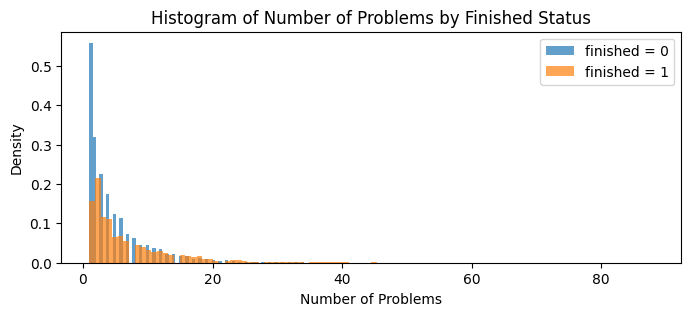

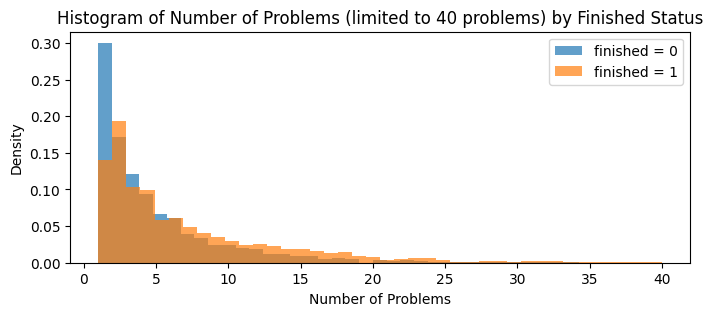

In [21]:
# number of problems per assignment for finished and non-finished assignments

num_probs = (
    df.groupby(["assignment_finished", "assignment_log_id"])
    .size()
    .reset_index()
    .rename(columns={0: "num_problems"})
)
display(num_probs)

plt.figure(figsize=(8, 3))
for val in [0, 1]:
    df_fin = num_probs.loc[num_probs["assignment_finished"] == val].copy()
    plt.hist(
        df_fin["num_problems"],
        bins=100,
        density=True,
        alpha=0.7,
        label=f"finished = {val}",
    )
plt.xlabel("Number of Problems")
plt.ylabel("Density")
plt.title("Histogram of Number of Problems by Finished Status")
plt.legend()
plt.show()

num_probs_rest = num_probs.loc[num_probs["num_problems"] <= 40].copy()
plt.figure(figsize=(8, 3))
for val in [0, 1]:
    df_fin = num_probs_rest.loc[num_probs_rest["assignment_finished"] == val].copy()
    plt.hist(
        df_fin["num_problems"],
        bins=40,
        density=True,
        alpha=0.7,
        label=f"finished = {val}",
    )
plt.xlabel("Number of Problems")
plt.ylabel("Density")
plt.title("Histogram of Number of Problems (limited to 40 problems) by Finished Status")
plt.legend()
plt.show()


We have a look at how the non-finished problems are distributed among the non-finished assignments and see that every assignment has at most one non-finished problem. This gives rise to the assumption that this is because of missing data. Hence, we decide to keep the non-finished assignments but remove the non-finished problems.

In [22]:
# get number of non-finished problems per assignment
num_non_fin = df.loc[df["problem_finished"] == 0].groupby("assignment_log_id").size()
len(num_non_fin[num_non_fin != 1])  # 0

0

In [23]:
print("Before dropping non-finished problems:")
print(f"Number of rows: {len(df)}, Number of assignments: {df['assignment_log_id'].nunique()}")
# 3499440, 534092

# drop non-finished problems
df = df.loc[df["problem_finished"] == 1].copy()
df = df.drop(columns=["problem_finished"])

print("After dropping non-finished problems:")
print(f"Number of rows: {len(df)}, Number of assignments: {df['assignment_log_id'].nunique()}")
# 3484822, 529048

Before dropping non-finished problems:
Number of rows: 3499440, Number of assignments: 534092
After dropping non-finished problems:
Number of rows: 3484822, Number of assignments: 529048


In [25]:
df_save = df.copy()
if SAVE_SECONDARY_FILES:
    utils.save_as_csv(df, "data_matrix_in_units.csv", save_idx=False)

## Preparing the UT Assignments

according to Subsection 4.4.2

- Merge assignment details to unit test scores data frame. Then, drop problems that are not in problem_details.
- We remove assignments with less than 3 problems.

In [26]:
unit_test_scores = unit_test_scores_orig.merge(
    assignment_details[["sequence_id", "student_id", "class_id", "teacher_id"]],
    how="left",
    left_on="assignment_log_id",
    right_index=True,
)
unit_test_scores = unit_test_scores.rename(columns={"score": "first_answer"})
print(len(unit_test_scores))  # 452439
unit_test_scores.head()

452439


,assignment_log_id,problem_id,first_answer,sequence_id,student_id,class_id,teacher_id
0,1CEASUAUQJ,18J6436AS5,1,2EQIAX4CBK,20O0YNR2NT,2P3DYNIXW5,2BO44R4ZJ6
1,2IMKPEIL2Q,9RMI4CZU9,0,2EQIAX4CBK,2L0ZB5CHH6,27WWOI3I22,23ZQUWTVNJ
2,2IMKPEIL2Q,8F4U5WWTV,0,2EQIAX4CBK,2L0ZB5CHH6,27WWOI3I22,23ZQUWTVNJ
3,2IMKPEIL2Q,27D3I359NE,1,2EQIAX4CBK,2L0ZB5CHH6,27WWOI3I22,23ZQUWTVNJ
4,2IMKPEIL2Q,22DY4PFVMV,1,2EQIAX4CBK,2L0ZB5CHH6,27WWOI3I22,23ZQUWTVNJ


In [27]:
# remove problems that are not in problem_details
num_prob_old = unit_test_scores["problem_id"].nunique()
len_old = len(unit_test_scores)
unit_test_scores = unit_test_scores.loc[unit_test_scores["problem_id"].isin(problem_details.index)]
num_prob_new = unit_test_scores["problem_id"].nunique()
len_new = len(unit_test_scores)
print(f"Removed {num_prob_old - num_prob_new} problems corresponding to {len_old - len_new} rows.")
# 148, 39418

Removed 148 problems corresponding to 39418 rows.


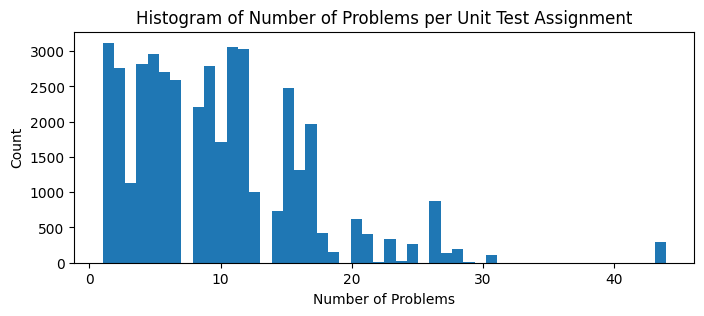

3120 assignments (7.38%) have less than 2 problems
5881 assignments (13.92%) have less than 3 problems
7006 assignments (16.58%) have less than 4 problems
9818 assignments (23.23%) have less than 5 problems
12785 assignments (30.25%) have less than 6 problems
15492 assignments (36.66%) have less than 7 problems


In [28]:
num_probs = unit_test_scores.groupby("assignment_log_id")["problem_id"].nunique()

plt.figure(figsize=(8, 3))
plt.hist(num_probs, bins=50)
plt.xlabel("Number of Problems")
plt.ylabel("Count")
plt.title("Histogram of Number of Problems per Unit Test Assignment")
plt.show()

for n in range(2, 8):
    num = len(num_probs[num_probs < n])
    prop = num / len(num_probs)
    print(f"{num} assignments ({prop * 100:.2f}%) have less than {n} problems")

We decide to make the cut-off at 3, that is we only keep unit test assignments having at least 3 problems.

In [29]:
drop_ass = num_probs[num_probs < 3].index

old_len = len(unit_test_scores)
unit_test_scores = unit_test_scores.loc[~unit_test_scores["assignment_log_id"].isin(drop_ass)]
new_len = len(unit_test_scores)
print(f"We dropped {old_len - new_len} out of {old_len} records")  # 8642, 413021

We dropped 8642 out of 413021 records


In [30]:
if SAVE_SECONDARY_FILES:
    utils.save_as_csv(unit_test_scores, "data_matrix_unit_tests.csv", save_idx=False)

## Combining UT and IU Data and Further Preprocessing

according to Subsection 4.4.3

In [31]:
df["unit_test"] = 0
unit_test_scores["unit_test"] = 1

In [32]:
df_total = pd.concat([df, unit_test_scores], axis=0, ignore_index=True)
df_total  # len=3889201

,assignment_log_id,problem_id,timestamp,available_core_tutoring,actions,num_actions,first_answer,num_tries,final_answer,help_requested,...,hint_requested,live_tutor_requested,hint_id,explanation_id,sequence_id,student_id,class_id,teacher_id,assignment_finished,unit_test
0,12LNLV9T5P,2MZER0YXHT,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,27GEL3MV6E,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
1,XJMWRTN1F,SXFPGQ0Z7,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
2,XJMWRTN1F,C4U09P1SM,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
3,XJMWRTN1F,1Q6NCCELIN,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
4,XJMWRTN1F,36DSFWGZG,1.587659e+09,no_tutoring,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3889196,624996B53,1WCXYWAT5D,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23IQP9IW3H,YMJ1TAWZC,Y0YWQKYLT,23M4G94FMN,NaN,1
3889197,624996B53,SAI1LT0AQ,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23IQP9IW3H,YMJ1TAWZC,Y0YWQKYLT,23M4G94FMN,NaN,1
3889198,624996B53,18LFM4VVCY,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23IQP9IW3H,YMJ1TAWZC,Y0YWQKYLT,23M4G94FMN,NaN,1
3889199,624996B53,1VUW3WTLJE,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23IQP9IW3H,YMJ1TAWZC,Y0YWQKYLT,23M4G94FMN,NaN,1


In [33]:
df_total_save = df_total.copy()
if SAVE_SECONDARY_FILES:
    utils.save_as_csv(df_total, "data_matrix_complete.csv", save_idx=False)

### Mapping Classes

6% of the students belong to more than one class. We therefore check the groups of students in each class and map classes with (almost) the same set of students.

In [34]:
# get data for students which are in multiple classes
num_classes_per_student = df_total.groupby("student_id")["class_id"].nunique()
mult_classes = num_classes_per_student[num_classes_per_student > 1].index
df_mult_classes = df_total.loc[df_total["student_id"].isin(mult_classes)]

# for each of those students get list of classes the student is in
grouped = df_mult_classes.groupby("student_id")
list_classes = grouped["class_id"].apply(pd.unique)
list_classes  # len=3477

student_id
100GVRIQ9W                [1CRVN37JO3, B41G0QVEU]
1019YFT1FX               [1WJPAT2TSM, 2QR917UMVD]
101REJ5EQU                 [H6OT8VAC7, NW1PATK44]
102OJOM6DE                [2CJILWUO52, REBXIL3ZD]
103C5LUCT6                [2KVPZQXWHG, K1H0TT01T]
                             ...                 
ZYN2I3UN1     [1BRQ4XCF7R, 203EUOOE0J, QN3BNEX3J]
ZYSEYQV8L                 [2LT3YI5CBF, W5S4BD5TU]
ZYU4E70CE                 [1T92BRJ98K, RH1F3F701]
ZZDWPSSTK                 [1SUVJQYSP2, PFZJFHQ65]
ZZXOBLN96                [1CK37Z7I4L, 1HOYP105CA]
Name: class_id, Length: 3474, dtype: object

In [35]:
# Example student in two classes
sid = "100GVRIQ9W"  # df_total.loc[df_total["student_id"] == sid, "class_id"].unique()
df_stud = df_total.loc[df_total["student_id"] == sid].copy()
cids = list_classes.loc[sid]
print("Classes:", cids)
print("Teachers:", df_stud["teacher_id"].unique())
num_seq_total = df_stud["sequence_id"].nunique()
num_seq_c1 = df_stud.loc[df_stud["class_id"] == cids[0], "sequence_id"].nunique()
num_seq_c2 = df_stud.loc[df_stud["class_id"] == cids[1], "sequence_id"].nunique()
print("Number of Sequences: Total:", num_seq_total, "Class 1:", num_seq_c1, "Class 2:", num_seq_c2)  # 55, 12, 43
# Sequences don't overlap

Classes: ['1CRVN37JO3' 'B41G0QVEU']
Teachers: ['2D3RZRRNFS']
Number of Sequences: Total: 55 Class 1: 12 Class 2: 43


Check for classes with identical set of students

In [36]:
# executing this cell takes approximately 3 minutes

# get set of students for each class
studs_per_class = df_total.groupby("class_id")["student_id"].apply(set)

# compare set of students for every two classes
classes = studs_per_class.index
class_to_class = pd.DataFrame(index=classes, columns=classes)
for idx1 in range(len(classes)-1):
    cid1 = classes[idx1]
    for cid2 in classes[idx1+1:]:
        # students in cid1 or cid2 which are not in both (Vereinigung ohne Schnitt)
        class_to_class.loc[cid1, cid2] = len(studs_per_class[cid1] ^ studs_per_class[cid2])
class_to_class

class_id,100VH25818,100XR0NJQW,101DWZ8JPV,101RQV99VA,1023GEVIHP,10316NNYUZ,103OAY5E1O,1044CIC9EN,104FM7VBNX,104P25L8L4,...,ZTEM6DIMJ,ZUBG8M8U,ZUO3DWRPU,ZVKPHZ0KS,ZW74W70XN,ZWBW3QERP,ZWTEIBTA3,ZXK4INTOW,ZXOBHJSKS,ZY24QW3NN
class_id,,,,,,,,,,,,,,,,,,,,,
100VH25818,NaN,27,33,23,16,18,24,26,28,37,...,36,24,15,18,40,29,22,35,14,33
100XR0NJQW,NaN,NaN,34,24,17,19,25,27,29,38,...,37,25,16,19,41,30,23,36,15,34
101DWZ8JPV,NaN,NaN,NaN,30,23,25,31,33,35,44,...,43,31,22,25,47,36,29,42,21,40
101RQV99VA,NaN,NaN,NaN,NaN,13,15,21,23,25,34,...,33,21,12,15,37,26,19,32,11,30
1023GEVIHP,NaN,NaN,NaN,NaN,NaN,8,14,16,18,27,...,26,14,5,8,30,19,12,25,4,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWBW3QERP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25,38,17,36
ZWTEIBTA3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,10,29
ZXK4INTOW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,42


In [37]:
if SAVE_SECONDARY_FILES:
    utils.save_as_csv(class_to_class, "class_students_comparison.csv", save_idx=True)

In [38]:
# number of class-class-combinations with identical set of students
print((class_to_class == 0).sum().sum())  # 33

# class-class-combinations with identical set of students
zero_pos = (class_to_class == 0).stack()
zero_idx = zero_pos[zero_pos].index

33


In [39]:
class_candidates = [cid for combi in zero_idx for cid in combi]
len(class_candidates), len(set(class_candidates))  # 66, 66
# no overlapping classes

(66, 66)

In [40]:
# explore combinations with identical sets of students
class_mapping, diff_classes = dict(), dict()
for cid1, cid2 in zero_idx:
    classes_equal, t_eq, seq_eq, l_eq = True, True, True, True
    # teachers
    t1 = set(df_total.loc[df_total["class_id"] == cid1, "teacher_id"])
    t2 = set(df_total.loc[df_total["class_id"] == cid2, "teacher_id"])
    if not t1 == t2:
        classes_equal, t_eq = False, False
        print(f"{cid1}, {cid2}: Teachers: C1: {t1}, C2: {t2}")
    
    # sequences
    seq1 = set(df_total.loc[df_total["class_id"] == cid1, "sequence_id"])
    seq2 = set(df_total.loc[df_total["class_id"] == cid2, "sequence_id"])
    seq_inters = seq1 & seq2
    if len(seq_inters) > 0:
        classes_equal, seq_eq = False, False
        print(f"{cid1}, {cid2}: Number of Sequences in both classes: {len(seq_inters)}")
    
    # sequence details
    seq_det1 = sequence_details.loc[sequence_details["sequence_id"].isin(seq1)].copy()
    seq_det2 = sequence_details.loc[sequence_details["sequence_id"].isin(seq2)].copy()
    # level 1
    l11 = set(seq_det1["sequence_folder_path_level_1"])
    l12 = set(seq_det2["sequence_folder_path_level_1"])
    if not l11 == l12:
        classes_equal, l_eq = False, False
        print(f"{cid1}, {cid2}: Level 1: C1: {l11}, C2: {l21}")
    # level 2
    l21 = set(seq_det1["sequence_folder_path_level_2"])
    l22 = set(seq_det2["sequence_folder_path_level_2"])
    if not l21 == l22:
        classes_equal, l_eq = False, False
        print(f"{cid1}, {cid2}: Level 2: C1: {l21}, C2: {l22}")
    
    if classes_equal:
        class_mapping[cid1] = cid2
    else:
        c_dict = {"cid2": cid2}
        if not t_eq:
            c_dict["teachers"] = (t1, t2)
        if not seq_eq:
            c_dict["sequences"] = (seq1, seq2)
            c_dict["sequence_intersec"] = seq_inters
        if not l_eq:
            c_dict["level1"] = (l11, l12)
            c_dict["level2"] = (l21, l22)
        diff_classes[cid1] = c_dict

class_mapping_save = class_mapping.copy()
diff_classes_save = diff_classes.copy()

11FO9MU8FC, 9RF58PWY2: Teachers: C1: {'I4AP42I13'}, C2: {'2IIRLL9HXL'}
14RPSA9QM3, 28UFZF4W0D: Number of Sequences in both classes: 1
159LHQTAQM, 1MM39GBR7S: Teachers: C1: {'2B7IJA1NYI'}, C2: {'2B7IJA1NYI', '1ZBN0LX63R'}
1H218Z30OX, FWAEJ9BDO: Teachers: C1: {'1KG51YQDLQ'}, C2: {'W1J9SQ20R'}
1LUKJLZUWG, XRJL0Y59O: Number of Sequences in both classes: 1
1X6TXE3YAV, KF794BI3M: Teachers: C1: {'1BE28UBA7Q'}, C2: {'E3J1ZEMH2'}
1Y3D9PGDAT, 2PPAVP3G15: Number of Sequences in both classes: 1
2BFL1IGG5P, 2EEDF4AUCS: Teachers: C1: {'11P3OVGKUB'}, C2: {'23TLIEPQZE'}
2KSTRVIMJ3, 89DIMEGWU: Teachers: C1: {'O3QSRN93K'}, C2: {'1UXWQT6QCE'}
2YXUVVGP1, D8NMTC61G: Teachers: C1: {'1TPMOCIY1L'}, C2: {'6MF39FHRQ'}
P2T9W91R9, VCGMB68VH: Teachers: C1: {'246BHKQCQE'}, C2: {'2KUHSLLDSI'}


In [41]:
len(class_mapping), len(diff_classes)  # 22, 11

(22, 11)

Classes in `class_mapping` have the same teacher and the completed sequences do not overlap. Moreover, folder path levels 1 and 2 are equal. Hence, we treat them as the same classes and just map the class ids onto each other.

Classes in `diff_classes` have different teachers or the completed sequences overlap. However, folder path levels 1 and 2 are equal. Therefore, we decide to treat them as the same classes, too, and add them to `class_mapping`.

In [42]:
# add class combinations from diff_classes to class_mapping
for cid1, c_dict in diff_classes.items():
    class_mapping[cid1] = c_dict["cid2"]

Check for classes that only differ in few students.

In [43]:
# number of class-class-combinations that only differ in one student
print((class_to_class == 1).sum().sum())  # 37

# class-class-combinations that only differ in one student
one_pos = (class_to_class == 1).stack()
one_idx = one_pos[one_pos].index

37


In [44]:
# check if there are classes that appear in more than one of the class combinations
class_candidates_1 = [cid for combi in one_idx for cid in combi]
len(class_candidates_1), len(set(class_candidates_1))  # 74, 73
# one class appears in two combinations

(74, 73)

In [45]:
# there are no classes that appear in candidates for zero-difference and for one-difference
set(class_candidates) & set(class_candidates_1)

set()

In [46]:
# get class that appears in more than one combination
counter = Counter(class_candidates_1)
critical_classes = [cid for cid, num in counter.items() if num > 1]
print(critical_classes)

# get combinations in which this class appears and remove them from one_idx
critical_combis = [combi for combi in one_idx if combi[0] in critical_classes or combi[1] in critical_classes]
one_idx = [combi for combi in one_idx if combi not in critical_combis]
critical_combis

['1MEAZQCFW3']


[('10ZNA7XEGA', '1MEAZQCFW3'), ('1MEAZQCFW3', '3G8APLL63')]

In [47]:
cid1 = "10ZNA7XEGA"
cid2 = "1MEAZQCFW3"
cid3 = "3G8APLL63"

c1 = df_total.loc[df_total["class_id"] == cid1].copy()
c2 = df_total.loc[df_total["class_id"] == cid2].copy()
c3 = df_total.loc[df_total["class_id"] == cid3].copy()

# students
st1 = set(c1["student_id"])
st2 = set(c2["student_id"])
st3 = set(c3["student_id"])

# teachers
t1 = set(c1["teacher_id"])
t2 = set(c2["teacher_id"])
t3 = set(c3["teacher_id"])

len(st1), len(st2), len(st3), len(st1 & st2 & st3), len(t1), len(t2), len(t3), len(t1 & t2 & t3)
# three class can be mapped

(32, 31, 30, 30, 1, 1, 1, 1)

In [48]:
# add classes to classes for mapping
class_mapping[cid2] = cid1
class_mapping[cid3] = cid1

In [49]:
# explore remaining combinations
for combi in one_idx:
    c1 = df_total.loc[df_total["class_id"] == combi[0]].copy()
    c2 = df_total.loc[df_total["class_id"] == combi[1]].copy()

    # students
    st1 = set(c1["student_id"])
    st2 = set(c2["student_id"])

    # teachers
    t1 = set(c1["teacher_id"])
    t2 = set(c2["teacher_id"])
    if not len(st1 & st2) == len(st1) and not len(st1 & st2) == len(st2):
        print(combi[0], combi[1], len(st1), len(st2), len(st1 & st2), len(t1), len(t2), len(t1 & t2))

In [50]:
class_candidates = set(class_candidates) | set(class_candidates_1)
len(class_candidates)  # 139

139

For every of those class combinations, one class has one additional student compared to the other classes. As the difference is that small, we consider those classes as equal.

In [51]:
# add class combinations to class_mapping
for cid1, cid2 in one_idx:
    class_mapping[cid1] = cid2

In [52]:
if SAVE_SECONDARY_FILES:
    utils.save_as_json(class_mapping, "class_mapping.json")

In [53]:
# map classes in df_total
print(len(class_mapping))  # 70
for cid1, cid2 in class_mapping.items():
    df_total.loc[df_total["class_id"] == cid1, "class_id"] = cid2

70


In [54]:
df_total["class_id"].nunique(), df_total["student_id"].nunique()  # classes=2971, students=35611

(2971, 35611)

In [55]:
df_classes_mapped = df_total.copy()
if SAVE_SECONDARY_FILES:
    utils.save_as_csv(df_total, "data_matrix_complete_classes_mapped.csv", save_idx=False)

### UT Sequences worked on multiple Times by the same Student

There are students that completed the same UT sequence multiple times (in different assignments) in the same class, where only one of that exists due to the performed class mapping. As this results in multiple test cases with the same underlying UT sequence and the same IU data that is used for training, but possibly with different results in the corresponding UT assignments, we decided to only keep one assignment per UT sequence and class.

Strategy: Walways use the longest assignment. If two assignments have the same length, we use the assignment that was scheduled earlier.

In [56]:
# get data for unit test assignments
uts = df_total.loc[df_total["unit_test"] == 1].copy()
len(uts), uts["assignment_log_id"].nunique()  # 404379, 36378

(404379, 36378)

In [57]:
# map classes in assignment_details
print(len(class_mapping))  # 70
for cid1, cid2 in class_mapping.items():
    assignment_details.loc[assignment_details["class_id"] == cid1, "class_id"] = cid2

ass_det_uts = assignment_details.loc[uts["assignment_log_id"].unique()].copy()
ass_det_uts.head()

70


,teacher_id,class_id,student_id,sequence_id,assignment_release_date,assignment_due_date,assignment_start_time,assignment_end_time
assignment_log_id,,,,,,,,
1CEASUAUQJ,2BO44R4ZJ6,2P3DYNIXW5,20O0YNR2NT,2EQIAX4CBK,1.619058e+09,1.621131e+09,REMOVED_FOR_EVALUATION,REMOVED_FOR_EVALUATION
2IMKPEIL2Q,23ZQUWTVNJ,27WWOI3I22,2L0ZB5CHH6,2EQIAX4CBK,1.583758e+09,NaN,REMOVED_FOR_EVALUATION,REMOVED_FOR_EVALUATION
2MZN9L748R,2D7TTJJY0I,ITIFIXYP0,XCMDO5GJB,2EQIAX4CBK,1.583758e+09,NaN,REMOVED_FOR_EVALUATION,REMOVED_FOR_EVALUATION
23JSHE2SVE,2D7TTJJY0I,ITIFIXYP0,VUKUXMHFM,2EQIAX4CBK,1.583758e+09,NaN,REMOVED_FOR_EVALUATION,REMOVED_FOR_EVALUATION
D0CP64A53,2D7TTJJY0I,ITIFIXYP0,M6TVU2UAX,2EQIAX4CBK,1.583758e+09,NaN,REMOVED_FOR_EVALUATION,REMOVED_FOR_EVALUATION


In [58]:
# get number of unique assignment ids per class-student-sequence combination
num_ass = (
    uts.groupby(["class_id", "student_id", "sequence_id"])["assignment_log_id"]
    .nunique()
    .to_frame()
)
# restrict to combinations where more than one unique assignment exists
num_ass = num_ass.loc[num_ass["assignment_log_id"] > 1]
num_ass  # len=1847

assignment_log_id
class_id   student_id sequence_id                   
103OAY5E1O 1PTCG7F3IE 42ZJIQBIE                    2
104P25L8L4 7RCY26EOE  2DRIUYX4MA                   2
108S5YTIHT AO1Y7WSFF  75X9G60NB                    3
10O0CFM4TG 119XX24Q77 2EQIAX4CBK                   2
           1CJXUGL3UG 2EQIAX4CBK                   2
...                                              ...
XWRYQ8B5P  29YJGE6TV7 21O576G5H3                   2
           9XNLZHWA8  21O576G5H3                   2
YWJ30GDW3  E4XTVFY0F  1QO6DRI4PV                   2
ZNRFPGR3B  10S1U21AWP 2DRIUYX4MA                   2
           2OABE4KPO0 2DRIUYX4MA                   2

[1847 rows x 1 columns]

In [59]:
# get length of assignment for each class-student-sequence combination
len_ass = (
    uts.groupby(["class_id", "student_id", "sequence_id", "assignment_log_id"])
    .size()
    .to_frame()
    .rename(columns={0: "len_ass"})
)

# get assignment_release_date
rel_dates = ass_det_uts.reset_index().set_index(
    ["class_id", "student_id", "sequence_id", "assignment_log_id"]
)["assignment_release_date"]
ass_det = len_ass.merge(rel_dates, how="left", left_index=True, right_index=True)
print(len(ass_det))  # len=36378

# restrict to assignments for double-sequence cases
idx_cols_small = ["class_id", "student_id", "sequence_id"]
ass_det = ass_det.reset_index().set_index(idx_cols_small).loc[num_ass.index]
ass_det  # len=3903

36378


assignment_log_id  len_ass  \
class_id   student_id sequence_id                              
103OAY5E1O 1PTCG7F3IE 42ZJIQBIE          1221LFVCZZ        4   
                      42ZJIQBIE           HXP2UHM2F        3   
104P25L8L4 7RCY26EOE  2DRIUYX4MA         1ZM1E9LNML       17   
                      2DRIUYX4MA          PTBUL0KMS       13   
108S5YTIHT AO1Y7WSFF  75X9G60NB          23HJX3ZG34        5   
...                                             ...      ...   
YWJ30GDW3  E4XTVFY0F  1QO6DRI4PV         1MS5IP6CNQ        6   
ZNRFPGR3B  10S1U21AWP 2DRIUYX4MA         1IWRHYM0PI       13   
                      2DRIUYX4MA          D4QA7ZTHG       13   
           2OABE4KPO0 2DRIUYX4MA         12MGFLD6JM       13   
                      2DRIUYX4MA          ONLX135IE       13   

                                   assignment_release_date  
class_id   student_id sequence_id                           
103OAY5E1O 1PTCG7F3IE 42ZJIQBIE               1.605276e+09  
                      42ZJIQBIE               1.607619e+09  
104P25L8L4 7RCY26EOE  2DRIUYX4MA              1.589209e+09  
                      2DRIUYX4MA              1.586800e+09  
108S5YTIHT AO1Y7WSFF  75X9G60NB               1.632406e+09  
...                                                    ...  
YWJ30GDW3  E4XTVFY0F  1QO6DRI4PV              1.599624e+09  
ZNRFPGR3B  10S1U21AWP 2DRIUYX4MA              1.586360e+09  
                      2DRIUYX4MA              1.586269e+09  
           2OABE4KPO0 2DRIUYX4MA              1.586269e+09  
                      2DRIUYX4MA              1.586360e+09  

[3903 rows x 3 columns]

In [60]:
# restrict assignment relationships to relevant unit test assignments and in unit assignments that are in df_total
uts_ids = uts["assignment_log_id"].unique()
iu_ids = df_total.loc[df_total["unit_test"] == 0, "assignment_log_id"].unique()
assignment_relationships = assignment_relationships_orig.loc[
    (assignment_relationships_orig["unit_test_assignment_log_id"].isin(uts_ids))
    & (assignment_relationships_orig["in_unit_assignment_log_id"].isin(iu_ids))
].rename(
    columns={
        "unit_test_assignment_log_id": "ut_id",
        "in_unit_assignment_log_id": "iu_id",
    }
)

# assignments in ass_det (double-sequence cases) that are not in iu_per_ut
# for those, there do not exist any in unit assignments (there are not any in assignments_relationships)
ut_wo_iu = set(ass_det["assignment_log_id"]) - set(assignment_relationships["ut_id"])
print(f"{len(ut_wo_iu)} unit test assignments without in unit assignments")  # 32

# get original index
ass_det = ass_det.reset_index().set_index(idx_cols_small + ["assignment_log_id"])
print(len(ass_det))  # 3903
ass_det.head()

32 unit test assignments without in unit assignments
3903


len_ass  \
class_id   student_id sequence_id assignment_log_id            
103OAY5E1O 1PTCG7F3IE 42ZJIQBIE   1221LFVCZZ               4   
                                  HXP2UHM2F                3   
104P25L8L4 7RCY26EOE  2DRIUYX4MA  1ZM1E9LNML              17   
                                  PTBUL0KMS               13   
108S5YTIHT AO1Y7WSFF  75X9G60NB   23HJX3ZG34               5   

                                                     assignment_release_date  
class_id   student_id sequence_id assignment_log_id                           
103OAY5E1O 1PTCG7F3IE 42ZJIQBIE   1221LFVCZZ                    1.605276e+09  
                                  HXP2UHM2F                     1.607619e+09  
104P25L8L4 7RCY26EOE  2DRIUYX4MA  1ZM1E9LNML                    1.589209e+09  
                                  PTBUL0KMS                     1.586800e+09  
108S5YTIHT AO1Y7WSFF  75X9G60NB   23HJX3ZG34                    1.632406e+09

In general, we keep the longest assignment. If this is not unique, we take the earlier assignment (among the longest).

However, before performing this, we check that for each unit test assignment there are corresponding in unit assignments. If for one assignment there are no corresponding in unit assignments, we drop this one and determine the longest assignment among the remaining ones (for which there are in unit assignments). If for one sequence id, there are not any in unit assignments, we keep the longest unit test assignment (as this will be dropped later anyway).

In [61]:
drop_ass = []

for combi in num_ass.index:
    df_combi = ass_det.loc[combi].copy()
    combi_ut_w_iu = set(df_combi.index) - ut_wo_iu

    # check if all ut assignments do not have any iu assignments
    if len(combi_ut_w_iu) == 0:
        # all assignment ids in df_combi are in ut_wo_iu
        # that is, all of them do not have any corresponding in unit assignment
        # keep the longest assignment
        drop_ass.extend(df_combi.sort_values(["len_ass", "assignment_release_date"], ascending=[False, True]).index[1:])
    elif len(combi_ut_w_iu) == 1:
        # there is exactly one unit test assignment that has corresponding in unit assignments
        # drop other assignments
        drop_ass.extend(list(set(df_combi.index) & ut_wo_iu))
    else:
        # there are more than one unit test assignments that have corresponding in unit assignments
        # drop assignments without in unit assignments
        drop_ass.extend(list(set(df_combi.index) & ut_wo_iu))

        # restrict df_combi to possible unit test assignments
        # sort by length of assignment and release date
        # take longest assignment, if not unique, take earlier scheduled assignment
        drop_ass.extend(df_combi.loc[list(combi_ut_w_iu)].sort_values(["len_ass", "assignment_release_date"], ascending=[False, True]).index[1:])

len(drop_ass)  # 2056

2056

In [62]:
# drop unit test assignments in drop_ass
len_before = len(df_total)
df_total = df_total.loc[~df_total["assignment_log_id"].isin(drop_ass)].copy()
len_diff = len_before - len(df_total)
print(f"{len_diff} rows have been dropped that belonged to {len(drop_ass)} unit test assignemnts")
# 20327, 2056

20327 rows have been dropped that belonged to 2056 unit test assignemnts


Of course, we should also drop the in unit assignments that belonged to the just dropped unit test assignments but not to the kept ones. This is indeed important for the predictions: We will predict the performance in the unit test based on the corresponding in unit assignments. Therefore, all in unit assignments that do not belong to any of the remaining unit test assignments should be dropped, as well as all unit test assignments that do not have any in unit assignments left for prediction.

We will perform this restriction at a later point. For now, we will go on performing all further analysis such that we can keep the maximal data for as long as possible. This is important because it might be possible, that we will follow other prediction goals in the future, where we do not use corresponding IU assignments for prediction but all IU assignments.

### Restricting Sequences, Students and Classes

- Remove students that completed only IU or only UT assignments.
- Remove students that completed less than 5 IU problems.

In [64]:
# restrict assignment_relationships to ut assignments and iu assignments in df_total
ut_ass = df_total.loc[df_total["unit_test"] == 1, "assignment_log_id"].unique()
iu_ass = df_total.loc[df_total["unit_test"] == 0, "assignment_log_id"].unique()
print("Number of assignments in df_total")
print(f"Unit test assignments: {len(ut_ass)}, in-unit assignments: {len(iu_ass)}")  # 34322, 529048

assignment_relationships = assignment_relationships.loc[
    (assignment_relationships["ut_id"].isin(ut_ass))
    & (assignment_relationships["iu_id"].isin(iu_ass))
].reset_index(drop=True)
print("assignment_relationships")
print(f"Number of rows: {len(assignment_relationships)}")  # 364429
print(
    f"Number of distinct test assignments: {assignment_relationships['ut_id'].nunique()}"
)  # 33453
print(
    f"Number of distinct in unit assignments: {assignment_relationships['iu_id'].nunique()}"
)  # 360849

Number of assignments in df_total
Unit test assignments: 34322, in-unit assignments: 529048
assignment_relationships
Number of rows: 364434
Number of distinct test assignments: 33453
Number of distinct in unit assignments: 360854


In [65]:
# restrict df to relevant UT and IU assignments
ut_ass = set(assignment_relationships["ut_id"])
iu_ass = set(assignment_relationships["iu_id"])
old_len = len(df_total)
df_rest = df_total.loc[df_total["assignment_log_id"].isin(list(ut_ass | iu_ass))].reset_index(drop=True)
print(f"Number of rows dropped: {old_len - len(df_rest)}")  # 1130818

Number of rows dropped: 1130821


In [66]:
# Each assignment takes place in only one class
num_classes_per_ass = df_rest.groupby("assignment_log_id")["class_id"].nunique()
num_classes_per_ass[num_classes_per_ass > 1]

Series([], Name: class_id, dtype: int64)

In [67]:
# for each assignment get corresponding sequence_id, student, class, and teacher
df_ass = df_rest.drop_duplicates(subset=["assignment_log_id"])[
    [
        "assignment_log_id",
        "sequence_id",
        "student_id",
        "class_id",
        "teacher_id",
        "unit_test",
    ]
].set_index("assignment_log_id")
print(len(df_ass))  # 394302
df_ass.head()

394307


,sequence_id,student_id,class_id,teacher_id,unit_test
assignment_log_id,,,,,
12LNLV9T5P,27GEL3MV6E,125OTT0E74,100VH25818,WOOQUZY13,0
XJMWRTN1F,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,0
10TVDLEPIS,2BD69MKOWO,125OTT0E74,100VH25818,WOOQUZY13,0
LUO3R7G54,2H0XTG4HOY,125OTT0E74,100VH25818,WOOQUZY13,0
1HOQRGZUE,1F91W0EUHW,125OTT0E74,100VH25818,WOOQUZY13,0


In [68]:
# get sequence_id, student_id, class_id and teacher_id for unit test assignments
ass_rel = assignment_relationships.merge(
    df_ass[["sequence_id", "student_id", "class_id", "teacher_id"]],
    how="left",
    left_on="ut_id",
    right_index=True,
)

# get sequence_id, student_id, class_id and teacher_id for in-unit assignments
ass_rel = ass_rel.merge(
    df_ass[["sequence_id", "student_id", "class_id", "teacher_id"]],
    how="left",
    left_on="iu_id",
    right_index=True,
    suffixes=["_ut", "_iu"],
)
ass_rel  # len=364429

,ut_id,iu_id,sequence_id_ut,student_id_ut,class_id_ut,teacher_id_ut,sequence_id_iu,student_id_iu,class_id_iu,teacher_id_iu
0,38M6IA4SS,2DQG3SWWLS,CD76U7XEG,1VUKTJH0DS,2JFV80TTBO,1MBR5ZXN41,2JJ7KO37DN,1VUKTJH0DS,5TFYYKQGG,1FQE77ST0
1,15XW17EHLW,Y3G0XTLMF,CD76U7XEG,PI712SWCZ,C4EIV9P0E,FBDMWTDBZ,2JJ7KO37DN,PI712SWCZ,C4EIV9P0E,FBDMWTDBZ
2,2C5IG7FC12,1HLYER60XW,CD76U7XEG,70FNFVSRP,C4EIV9P0E,FBDMWTDBZ,2JJ7KO37DN,70FNFVSRP,C4EIV9P0E,FBDMWTDBZ
3,F9OJCBCRM,1XB8H1OIF8,CD76U7XEG,11WHZOTNO5,EGEHUE9HG,QZG8FU7X7,2JJ7KO37DN,11WHZOTNO5,EGEHUE9HG,QZG8FU7X7
4,K6IE7PFC7,RIFQE6J73,CD76U7XEG,40KA444QZ,1FN3UGSKCC,QZG8FU7X7,2JJ7KO37DN,40KA444QZ,1FN3UGSKCC,QZG8FU7X7
...,...,...,...,...,...,...,...,...,...,...
364429,17EUNRKIC4,10L0HSZBOL,2OMFIAVLSP,1O6Q4YZ1MU,UNH6L2OH3,1OH46I2WR8,1Q7ENQHCE1,1O6Q4YZ1MU,UNH6L2OH3,1OH46I2WR8
364430,2PNRH0FF5C,1XVZ3E4Z91,2OMFIAVLSP,20WNQ1L59I,1QV504I70A,1OH46I2WR8,6XV73PRE3,20WNQ1L59I,1QV504I70A,1OH46I2WR8
364431,17EUNRKIC4,3CDY32QZV,2OMFIAVLSP,1O6Q4YZ1MU,UNH6L2OH3,1OH46I2WR8,6XV73PRE3,1O6Q4YZ1MU,UNH6L2OH3,1OH46I2WR8
364432,2PNRH0FF5C,VHKYLCVSH,2OMFIAVLSP,20WNQ1L59I,1QV504I70A,1OH46I2WR8,AQFLKVGCA,20WNQ1L59I,1QV504I70A,1OH46I2WR8


In [69]:
# number of cases where student of ut_ass and iu_ass is not the same
len(ass_rel.loc[ass_rel["student_id_ut"] != ass_rel["student_id_iu"]])  # 0
# all corresponding in unit assignments have been completed by the same student

0

In [70]:
# cases where classes of ut_ass and iu_ass are not the same
ass_rel_diff = ass_rel.loc[ass_rel["class_id_ut"] != ass_rel["class_id_iu"]].copy()
ass_rel_diff  # 11597

,ut_id,iu_id,sequence_id_ut,student_id_ut,class_id_ut,teacher_id_ut,sequence_id_iu,student_id_iu,class_id_iu,teacher_id_iu
0,38M6IA4SS,2DQG3SWWLS,CD76U7XEG,1VUKTJH0DS,2JFV80TTBO,1MBR5ZXN41,2JJ7KO37DN,1VUKTJH0DS,5TFYYKQGG,1FQE77ST0
15,16C3K1VB4A,23GBMGOBTJ,CD76U7XEG,1MESTUDVQN,2JFV80TTBO,1MBR5ZXN41,2JJ7KO37DN,1MESTUDVQN,5TFYYKQGG,1FQE77ST0
116,38M6IA4SS,19TOXBU7V9,CD76U7XEG,1VUKTJH0DS,2JFV80TTBO,1MBR5ZXN41,2T42B3UC5,1VUKTJH0DS,5TFYYKQGG,1FQE77ST0
118,16C3K1VB4A,20Y3WI1EEK,CD76U7XEG,1MESTUDVQN,2JFV80TTBO,1MBR5ZXN41,2T42B3UC5,1MESTUDVQN,5TFYYKQGG,1FQE77ST0
164,27CQO22WWF,2G9UYQUZ0N,CD76U7XEG,CJG7D4XMN,2F1HHNOA80,2H4IINPK81,2T42B3UC5,CJG7D4XMN,EWM005RYM,2H4IINPK81
...,...,...,...,...,...,...,...,...,...,...
357823,1GE93O07WN,YQFHYLLAJ,FH0LL5EWZ,2CC6ME0LRP,29GM3BG5J5,28DC2JSOCN,1V9BWXTSVW,2CC6ME0LRP,1HF5F7NV8U,28DC2JSOCN
357824,1IQUAUS56P,1CVJTV570V,FH0LL5EWZ,7TRXWGX2F,29GM3BG5J5,28DC2JSOCN,1V9BWXTSVW,7TRXWGX2F,1HF5F7NV8U,28DC2JSOCN
360628,11XM4CQI5E,13C5N1CDM0,2N3U5AFYP4,11W17EXXEB,A91J81FZC,1R2DQB0IEA,28O7QZBM2M,11W17EXXEB,1C703P39TH,1R2DQB0IEA
360678,6GECCDEQI,YW844VGRL,2J2RMWVC09,20S9482BKE,1E35V06UZM,KP7PAW2P7,1UTJ3O8W0,20S9482BKE,2FPD940DT7,KP7PAW2P7


In [71]:
ass_rel_diff["ut_id"].nunique(), ass_rel["ut_id"].nunique()  # 1516, 33453

(1516, 33453)

For 1516 UT assignments (out of 33453), (some of) the corresponding IU assignments have been completed in a different class (but by the same student).

We leave it like that for now and, especially, we will keep all classes.

Because of the just performed analyses, we cannot drop those classes that only worked on UT sequences or on IU sequences. However, as for the predictions both UT and IU sequences are necessary, we will only consider classes that worked on both categories. We will deal with this later on.

However, we remove students that only worked on UT or IU sequences.

In [72]:
# get number of unit test and in unit sequences per student
num_sequences = df_total.groupby(["student_id", "unit_test"])["sequence_id"].nunique().reset_index()
num_sequences = (
    num_sequences.pivot(index="student_id", columns="unit_test", values="sequence_id")
    .fillna(0)
    .rename(columns={0: "num_in_units", 1: "num_unit_tests"})
)

# get students that did no unit test or no in unit sequences or both
mask_no_unit_tests = num_sequences["num_unit_tests"] == 0
mask_no_in_units = num_sequences["num_in_units"] == 0
students_both = num_sequences.loc[~mask_no_unit_tests & ~mask_no_in_units].index
print(f"Number of students that did not work on unit test sequences: {mask_no_unit_tests.sum()}")  # 11662
print(f"Number of students that did not work on in-unit sequences: {mask_no_in_units.sum()}")  # 562
print(f"Number of students that worked on both ut and iu sequences: {len(students_both)}")  # 23387

# restrict to students that worked on both unit tests and in unit sequences
df_small = df_total.loc[df_total["student_id"].isin(students_both)].reset_index(drop=True).copy()
print(f"{len(df_total) - len(df_small)} rows dropped resulting in {len(df_small)} rows.")
# 913480, 2955394
df_small.head()

Number of students that did not work on unit test sequences: 11662
Number of students that did not work on in-unit sequences: 562
Number of students that worked on both ut and iu sequences: 23387
913480 rows dropped resulting in 2955394 rows.


,assignment_log_id,problem_id,timestamp,available_core_tutoring,actions,num_actions,first_answer,num_tries,final_answer,help_requested,...,hint_requested,live_tutor_requested,hint_id,explanation_id,sequence_id,student_id,class_id,teacher_id,assignment_finished,unit_test
0,12LNLV9T5P,2MZER0YXHT,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,27GEL3MV6E,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
1,XJMWRTN1F,SXFPGQ0Z7,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
2,XJMWRTN1F,C4U09P1SM,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
3,XJMWRTN1F,1Q6NCCELIN,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
4,XJMWRTN1F,36DSFWGZG,1.587659e+09,no_tutoring,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0


In [73]:
df_small["class_id"].nunique(), df_small["student_id"].nunique()   # classes=2165, students=23387

(2165, 23387)

Remove students with less than 5 different IU problems.

In [74]:
# number of problems in in-unit assignments per student
num_problems = df_small.loc[df_small["unit_test"] == 0].groupby("student_id")["problem_id"].nunique()
# how many students are there with x different problems in in-unit assignments
num_problems.value_counts().sort_index(ascending=True)

problem_id
1       286
2       539
3       368
4       456
5       432
       ... 
1877      1
1889      1
1900      1
2029      1
2231      1
Name: count, Length: 874, dtype: int64

In [75]:
stud_less_5 = num_problems[num_problems < 5].index
print(f"Remove {len(stud_less_5)} students as they completed less than 5 iu problems.")  # 1649
df_small = df_small.loc[~df_small["student_id"].isin(stud_less_5)].copy()
print(len(df_small))  # 2935101
df_small.head()

Remove 1649 students as they completed less than 5 iu problems.
2935101


,assignment_log_id,problem_id,timestamp,available_core_tutoring,actions,num_actions,first_answer,num_tries,final_answer,help_requested,...,hint_requested,live_tutor_requested,hint_id,explanation_id,sequence_id,student_id,class_id,teacher_id,assignment_finished,unit_test
0,12LNLV9T5P,2MZER0YXHT,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,27GEL3MV6E,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
1,XJMWRTN1F,SXFPGQ0Z7,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
2,XJMWRTN1F,C4U09P1SM,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
3,XJMWRTN1F,1Q6NCCELIN,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
4,XJMWRTN1F,36DSFWGZG,1.587659e+09,no_tutoring,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0


In [76]:
df_small["class_id"].nunique(), df_small["student_id"].nunique()   # classes=2071, students=21738

(2071, 21738)

In [77]:
# sort data matrix by class, student and timestamp
# order of completion of assignments and problems is preserved for each student
df_small = df_small.sort_values(by=["class_id", "student_id", "timestamp"]).reset_index(drop=True)
df_small.head()

,assignment_log_id,problem_id,timestamp,available_core_tutoring,actions,num_actions,first_answer,num_tries,final_answer,help_requested,...,hint_requested,live_tutor_requested,hint_id,explanation_id,sequence_id,student_id,class_id,teacher_id,assignment_finished,unit_test
0,12LNLV9T5P,2MZER0YXHT,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,27GEL3MV6E,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
1,XJMWRTN1F,SXFPGQ0Z7,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
2,XJMWRTN1F,C4U09P1SM,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
3,XJMWRTN1F,1Q6NCCELIN,1.587658e+09,answer,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0
4,XJMWRTN1F,36DSFWGZG,1.587659e+09,no_tutoring,"[problem_started, correct_response, problem_fi...",3.0,1,1.0,1.0,0.0,...,0.0,0.0,NaN,NaN,1DHG1UNJ8Q,125OTT0E74,100VH25818,WOOQUZY13,1.0,0


In [78]:
if SAVE_PRIMARY_FILES:
    utils.save_as_csv(df_small, "data_matrix.csv", save_idx=False)